# Denver 2017 Bike Share Regression Modeling

## 1. Introduction

The data exploration performed on the Denver Trips dataset indicates weather variables have a significant impact on the number
of checkouts. This section will focus on investigating the use of various regression models on the Trips data when combined with weather variables.

In [1]:
# Import necessary libraries and functions that are needed for the analyses
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
# taken from Brandon Rhodes's Pandas Tutorial (https://github.com/brandon-rhodes)
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
dF = pd.read_csv("data/Denver_2017_Bike_Share_Trip_ML_Data.gz", dtype = {'Bike_Number' : object}, compression="gzip")

In [4]:
dF.shape

(322082, 15)

In [5]:
dF.head(1)

,User_Program,User_ID,Membership_Type,Bike_Number,Checkout_Date,Checkout_Hour,Checkout_Kiosk,Checkout_Method,Return_Date,Return_Time,Return_Kiosk,Trip_Duration,Trip_Distance,Checkout_WeekDay,Checkout_Month
0,Denver B-cycle,1478826,24 hour online (Denver B-cycle),324,2017-01-01,9,29th & Zuni,Mobile,2017-01-01,10:07:00,17th & Tejon,28,0.555,6,1


In [6]:
dF.drop(['User_Program'], axis = 1, inplace = True)
dF.drop(['Membership_Type'], axis = 1, inplace = True)
dF.drop(['User_ID'], axis = 1, inplace = True)
dF.drop(['Bike_Number'], axis = 1, inplace = True)
dF.drop(['Checkout_Kiosk'], axis = 1, inplace = True)
dF.drop(['Checkout_Method'], axis = 1, inplace = True)
dF.drop(['Return_Date'], axis = 1, inplace = True)
dF.drop(['Return_Kiosk'], axis = 1, inplace = True)
dF.drop(['Return_Time'], axis = 1, inplace = True)
dF.drop(['Trip_Duration'], axis = 1, inplace = True)
dF.drop(['Trip_Distance'], axis = 1, inplace = True)

In [7]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322082 entries, 0 to 322081
Data columns (total 4 columns):
Checkout_Date       322082 non-null object
Checkout_Hour       322082 non-null int64
Checkout_WeekDay    322082 non-null int64
Checkout_Month      322082 non-null int64
dtypes: int64(3), object(1)
memory usage: 9.8+ MB


### Re-arrange columns to set up target class

In [8]:
# re-arrange columns in preparation for training and test data
dF = dF[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour']]

In [9]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322082 entries, 0 to 322081
Data columns (total 4 columns):
Checkout_Date       322082 non-null object
Checkout_Month      322082 non-null int64
Checkout_WeekDay    322082 non-null int64
Checkout_Hour       322082 non-null int64
dtypes: int64(3), object(1)
memory usage: 9.8+ MB


In [10]:
dW = pd.read_csv("data/Denver_2017_Bike_Share_Hourly_Weather_Forecast.csv")

In [11]:
dW.rename(columns = {'Hour': 'Checkout_Hour'}, inplace = True)

In [12]:
dW['Checkout_WeekDay'] = pd.DatetimeIndex(dW['Date']).weekday

In [13]:
dW['Checkout_Month'] = pd.DatetimeIndex(dW['Date']).month

In [14]:
dFW = dF.groupby(['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 
                  'Checkout_Hour']).size().to_frame(name = 'Number_Of_Checkouts').reset_index()

In [15]:
dF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322082 entries, 0 to 322081
Data columns (total 4 columns):
Checkout_Date       322082 non-null object
Checkout_Month      322082 non-null int64
Checkout_WeekDay    322082 non-null int64
Checkout_Hour       322082 non-null int64
dtypes: int64(3), object(1)
memory usage: 9.8+ MB


In [16]:
dFW['Number_Of_Checkouts'].sum()

322082

In [17]:
dFW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 5 columns):
Checkout_Date          6864 non-null object
Checkout_Month         6864 non-null int64
Checkout_WeekDay       6864 non-null int64
Checkout_Hour          6864 non-null int64
Number_Of_Checkouts    6864 non-null int64
dtypes: int64(4), object(1)
memory usage: 268.2+ KB


In [18]:
dFW.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Number_Of_Checkouts
0,2017-01-01,1,6,7,2
1,2017-01-01,1,6,8,4
2,2017-01-01,1,6,9,10
3,2017-01-01,1,6,10,27
4,2017-01-01,1,6,11,19


In [19]:
dW.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
Date                   8760 non-null object
Checkout_Hour          8760 non-null int64
apparentTemperature    8760 non-null float64
cloudCover             8760 non-null float64
humidity               8760 non-null float64
temperature            8760 non-null float64
visibility             8760 non-null float64
windSpeed              8760 non-null float64
Checkout_WeekDay       8760 non-null int64
Checkout_Month         8760 non-null int64
dtypes: float64(6), int64(3), object(1)
memory usage: 684.5+ KB


In [20]:
dW.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay,Checkout_Month
0,2017-01-01,0,34.49,0.15,0.42,38.18,10.0,4.81,6,1
1,2017-01-01,1,34.38,0.13,0.39,40.14,10.0,8.77,6,1
2,2017-01-01,2,35.99,0.22,0.36,42.15,10.0,10.79,6,1
3,2017-01-01,3,36.00,0.13,0.37,41.58,10.0,9.09,6,1
4,2017-01-01,4,36.69,0.14,0.38,41.79,10.0,8.17,6,1


In [21]:
dT = pd.merge(dW, dFW, how='left', left_on=['Date', 'Checkout_Hour'], 
              right_on=['Checkout_Date', 'Checkout_Hour'])

In [22]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 14 columns):
Date                   8760 non-null object
Checkout_Hour          8760 non-null int64
apparentTemperature    8760 non-null float64
cloudCover             8760 non-null float64
humidity               8760 non-null float64
temperature            8760 non-null float64
visibility             8760 non-null float64
windSpeed              8760 non-null float64
Checkout_WeekDay_x     8760 non-null int64
Checkout_Month_x       8760 non-null int64
Checkout_Date          6863 non-null object
Checkout_Month_y       6863 non-null float64
Checkout_WeekDay_y     6863 non-null float64
Number_Of_Checkouts    6863 non-null float64
dtypes: float64(9), int64(3), object(2)
memory usage: 1.0+ MB


In [23]:
dT.tail()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
8755,2017-12-31,19,5.53,0.31,0.80,12.15,8.77,3.76,6,12,2017-12-31,12.0,6.0,2.0
8756,2017-12-31,20,3.68,0.26,0.82,10.97,9.18,4.07,6,12,2017-12-31,12.0,6.0,1.0
8757,2017-12-31,21,3.77,0.26,0.84,10.47,9.09,3.66,6,12,2017-12-31,12.0,6.0,2.0
8758,2017-12-31,22,3.84,0.20,0.82,10.16,8.81,3.41,6,12,2017-12-31,12.0,6.0,5.0
8759,2017-12-31,23,10.33,0.56,0.81,10.33,8.67,2.54,6,12,2017-12-31,12.0,6.0,3.0


In [24]:
dT['Number_Of_Checkouts'].sum()

322079.0

In [25]:
dT.isnull().values.any()

True

In [26]:
nan_rows = dT[dT.isnull().T.any().T]

In [27]:
dT = dT.drop(dT.index[nan_rows.index])

In [28]:
dT.isnull().values.any()

False

In [29]:
dT.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6863 entries, 7 to 8759
Data columns (total 14 columns):
Date                   6863 non-null object
Checkout_Hour          6863 non-null int64
apparentTemperature    6863 non-null float64
cloudCover             6863 non-null float64
humidity               6863 non-null float64
temperature            6863 non-null float64
visibility             6863 non-null float64
windSpeed              6863 non-null float64
Checkout_WeekDay_x     6863 non-null int64
Checkout_Month_x       6863 non-null int64
Checkout_Date          6863 non-null object
Checkout_Month_y       6863 non-null float64
Checkout_WeekDay_y     6863 non-null float64
Number_Of_Checkouts    6863 non-null float64
dtypes: float64(9), int64(3), object(2)
memory usage: 804.3+ KB


In [30]:
dT.head()

,Date,Checkout_Hour,apparentTemperature,cloudCover,humidity,temperature,visibility,windSpeed,Checkout_WeekDay_x,Checkout_Month_x,Checkout_Date,Checkout_Month_y,Checkout_WeekDay_y,Number_Of_Checkouts
7,2017-01-01,7,33.54,0.17,0.44,38.74,10.00,7.14,6,1,2017-01-01,1.0,6.0,2.0
8,2017-01-01,8,38.96,0.26,0.41,42.93,10.00,6.48,6,1,2017-01-01,1.0,6.0,4.0
9,2017-01-01,9,46.69,0.11,0.33,49.97,9.79,8.10,6,1,2017-01-01,1.0,6.0,10.0
10,2017-01-01,10,54.03,0.20,0.28,54.03,9.90,6.05,6,1,2017-01-01,1.0,6.0,27.0
11,2017-01-01,11,57.41,0.24,0.25,57.41,9.70,7.42,6,1,2017-01-01,1.0,6.0,19.0


In [31]:
dT.drop(['Date', 'Checkout_WeekDay_y', 'Checkout_Month_y'], axis = 1, inplace = True)
dT.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility',
                     'Checkout_WeekDay_x': 'Checkout_WeekDay', 'Checkout_Month_x': 'Checkout_Month'}, inplace = True)

### Discard Checkout_Hour <= 4 as there are no checkouts in these hours

In [32]:
dML = dT[~((dT.Checkout_Hour == 0)  | (dT.Checkout_Hour == 1)  | (dT.Checkout_Hour == 2)  | (dT.Checkout_Hour == 3)  |
         (dT.Checkout_Hour == 4))]

In [33]:
dML.shape

(6840, 11)

In [34]:
data = dML.copy(deep=True)

In [35]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

In [36]:
data = data[['Checkout_Date', 'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Humidity', 'Wind_Speed', 'Visibility', 'Number_Of_Checkouts']]

In [37]:
data.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts
7,2017-01-01,1,6,7,38.74,33.54,0.17,0.44,7.14,10.00,2.0
8,2017-01-01,1,6,8,42.93,38.96,0.26,0.41,6.48,10.00,4.0
9,2017-01-01,1,6,9,49.97,46.69,0.11,0.33,8.10,9.79,10.0
10,2017-01-01,1,6,10,54.03,54.03,0.20,0.28,6.05,9.90,27.0
11,2017-01-01,1,6,11,57.41,57.41,0.24,0.25,7.42,9.70,19.0


### Convert the numeric Calendar and Clock columns into categorical columns

In [38]:
month_dummies = pd.get_dummies(data.Checkout_Month, prefix='month')

In [39]:
weekday_dummies = pd.get_dummies(data.Checkout_WeekDay, prefix='weekday')

In [40]:
hour_dummies = pd.get_dummies(data.Checkout_Hour, prefix='hour')

In [41]:
data = pd.concat([data, month_dummies, weekday_dummies, hour_dummies], axis=1)

In [42]:
data.head()

,Checkout_Date,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Humidity,Wind_Speed,Visibility,Number_Of_Checkouts,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
7,2017-01-01,1,6,7,38.74,33.54,0.17,0.44,7.14,10.00,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,2017-01-01,1,6,8,42.93,38.96,0.26,0.41,6.48,10.00,4.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,2017-01-01,1,6,9,49.97,46.69,0.11,0.33,8.10,9.79,10.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,2017-01-01,1,6,10,54.03,54.03,0.20,0.28,6.05,9.90,27.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
11,2017-01-01,1,6,11,57.41,57.41,0.24,0.25,7.42,9.70,19.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### Keep 10 samples aside for use in prediction on unseen samples

In [43]:
dUT = data.sample(n=10, random_state=123)

In [44]:
del_rows = dUT.index

In [45]:
data.drop(del_rows, axis=0, inplace=True)

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6830 entries, 7 to 8759
Data columns (total 49 columns):
Checkout_Date           6830 non-null object
Checkout_Month          6830 non-null int64
Checkout_WeekDay        6830 non-null int64
Checkout_Hour           6830 non-null int64
Temperature             6830 non-null float64
Apparent_Temperature    6830 non-null float64
Cloud_Cover             6830 non-null float64
Humidity                6830 non-null float64
Wind_Speed              6830 non-null float64
Visibility              6830 non-null float64
Number_Of_Checkouts     6830 non-null float64
month_1                 6830 non-null uint8
month_2                 6830 non-null uint8
month_3                 6830 non-null uint8
month_4                 6830 non-null uint8
month_5                 6830 non-null uint8
month_6                 6830 non-null uint8
month_7                 6830 non-null uint8
month_8                 6830 non-null uint8
month_9                 6830 non-null uint

In [47]:
data = data[['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
             'Number_Of_Checkouts']]

In [48]:
data.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,Checkout_Month,Checkout_WeekDay,Checkout_Hour,Temperature,Apparent_Temperature,Cloud_Cover,Wind_Speed,Humidity,Visibility,Number_Of_Checkouts
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,7,38.74,33.54,0.17,7.14,0.44,10.00,2.0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,8,42.93,38.96,0.26,6.48,0.41,10.00,4.0
9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,9,49.97,46.69,0.11,8.10,0.33,9.79,10.0
10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,10,54.03,54.03,0.20,6.05,0.28,9.90,27.0
11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,6,11,57.41,57.41,0.24,7.42,0.25,9.70,19.0


In [49]:
array = data.values

In [50]:
X = array[:,0:47]
X[0]

array([ 1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  1.  ,  6.  ,  7.  , 38.74, 33.54,  0.17,  7.14,
        0.44, 10.  ])

In [51]:
y = array[:,47]
y[0]

2.0

## Feature Correlations

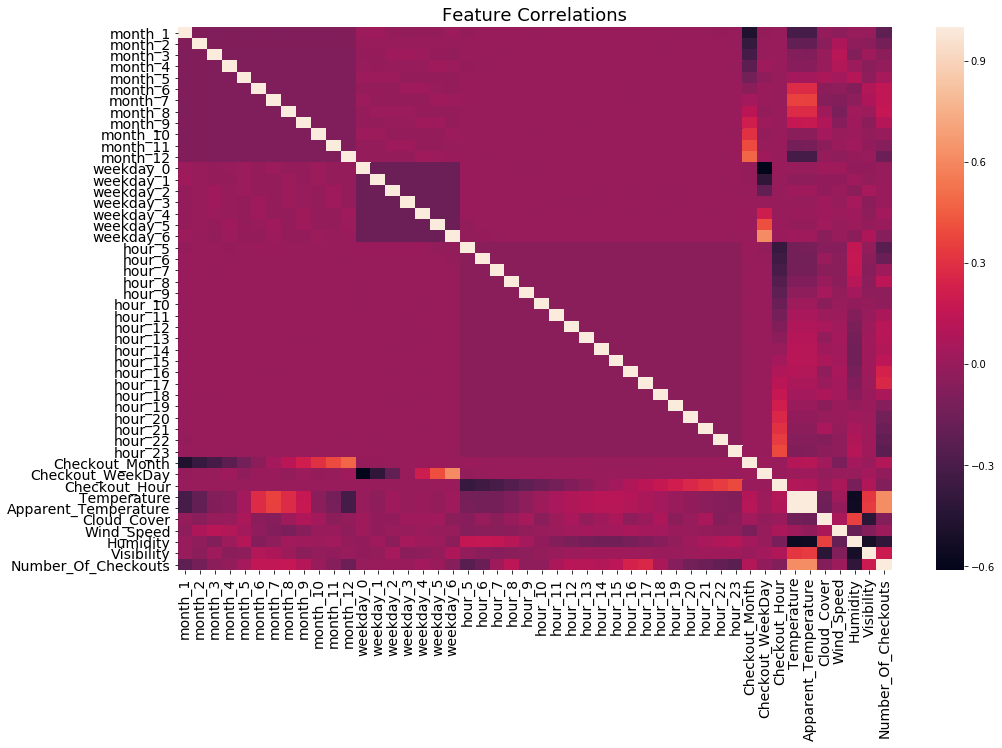

In [52]:
plt.figure(figsize=(16,10))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [53]:
features = ['month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
             'month_9', 'month_10', 'month_11', 'month_12',
             'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
             'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
             'hour_14', 'hour_15', 'hour_16', 'hour_17',
             'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
             'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## 2. Modeling - All Features

### Plot Feature Importance

In [54]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,14))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

### Get Regression Metrics

In [55]:
def get_regression_metrics(model, actual, predicted):
    regression_metrics = {'R Squared' : metrics.r2_score(actual, predicted)**0.5,
                          'RMSE' : metrics.mean_squared_error(actual, predicted)}
    dML_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    dML_metrics.columns = [model]
    return dML_metrics

### Linear Regression

In [56]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.intercept_: {}".format(lr.intercept_))
print("lr.coef_: {}".format(lr.coef_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.intercept_: 1294945477.0888085
lr.coef_: [ 5.41653445e+05  5.41661397e+05  5.41666766e+05  5.41669796e+05
  5.41675661e+05  5.41674879e+05  5.41671929e+05  5.41678156e+05
  5.41675783e+05  5.41672500e+05  5.41666326e+05  5.41661776e+05
  9.57780555e+10  9.57780555e+10  9.57780555e+10  9.57780555e+10
  9.57780555e+10  9.57780555e+10  9.57780555e+10 -9.70735427e+10
 -9.70735427e+10 -9.70735426e+10 -9.70735426e+10 -9.70735427e+10
 -9.70735427e+10 -9.70735427e+10 -9.70735426e+10 -9.70735426e+10
 -9.70735427e+10 -9.70735426e+10 -9.70735426e+10 -9.70735426e+10
 -9.70735426e+10 -9.70735427e+10 -9.70735427e+10 -9.70735427e+10
 -9.70735427e+10 -9.70735427e+10  1.07281452e+00 -2.85134040e-01
 -7.27059488e+00 -5.46293661e-01 -8.91272246e+00  9.94453378e-01]

Training Set Score: 0.683
Testing Set Score: 0.655


,Linear Regression
R Squared,0.809501
RMSE,486.352625


### Lasso Regression

In [57]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.01)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("lso.intercept_: {}".format(lso.intercept_))
print("lso.coef_: {}".format(lso.coef_))
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

lso.intercept_: 8.308090146520854
lso.coef_: [-15.87415504  -8.20743036  -3.2184427   -0.35789519   4.78081015
   3.53016791   0.24917262   6.65137055   4.584796     2.06236356
  -3.65716885  -7.60210363  -0.73147233   1.03613256  -0.36221255
   1.04073736   2.77457973   0.          -7.90232686 -39.04137186
 -24.7920564    5.33433564  21.03777102  -8.70181491 -12.81468998
   0.           8.46368392   5.44228386   0.           6.93692176
  24.93446863  29.75180385   3.19091077 -17.070747   -26.04720625
 -28.56539294 -34.25989589 -37.77344062   1.15068515  -0.30729163
  -6.69004462  -0.55508109  -7.06691221   1.0203238 ]
Training Set Score: 0.683
Testing Set Score: 0.655


C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Lasso Regression
R Squared,0.809247
RMSE,486.932107


### Ridge Regression

In [58]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.01)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("rge.intercept_: {}".format(rge.intercept_))
print("rge.coef_: {}".format(rge.coef_))
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

rge.intercept_: 8.308090146520854
rge.coef_: [-15.87415504  -8.20743036  -3.2184427   -0.35789519   4.78081015
   3.53016791   0.24917262   6.65137055   4.584796     2.06236356
  -3.65716885  -7.60210363  -0.73147233   1.03613256  -0.36221255
   1.04073736   2.77457973   0.          -7.90232686 -39.04137186
 -24.7920564    5.33433564  21.03777102  -8.70181491 -12.81468998
   0.           8.46368392   5.44228386   0.           6.93692176
  24.93446863  29.75180385   3.19091077 -17.070747   -26.04720625
 -28.56539294 -34.25989589 -37.77344062   1.15068515  -0.30729163
  -6.69004462  -0.55508109  -7.06691221   1.0203238 ]
Training Set Score: 0.683
Testing Set Score: 0.655


C:\Users\jbhasin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


,Ridge Regression
R Squared,0.809247
RMSE,486.932107


### Bayesian Ridge Regression

In [59]:
# Bayesian Ridge Regressor
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("brr.intercept_: {:.3f}".format(brr.intercept_))
print("brr.coef_: {}".format(brr.coef_))
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

brr.intercept_: 2.440
brr.coef_: [-15.07213339  -7.29913492  -2.12455053   0.83334048   6.48574579
   5.48569885   2.41987083   8.69349826   6.45420929   3.50135092
  -2.5503535   -6.82754207  -0.23569701   1.66195921   0.16767544
   1.72239589   3.45527828   0.58183481  -7.35344662 -32.53317217
 -18.40847843  11.83722594  27.45825253  -2.36777317  -6.42294909
   6.68995636  15.14052129  12.13518026   6.57986633  13.65022185
  31.44758969  36.22627844   9.85796754 -10.66059375 -19.56359458
 -22.07990517 -27.76113677 -31.22545708   1.10598766  -0.29501041
  -6.94697316  -0.54912267  -8.40324732   0.98870362]
Training Set Score: 0.683
Testing Set Score: 0.655


,Bayesion Ridge Regression
R Squared,0.809243
RMSE,486.941279


### Decision Tree Regression

In [60]:
# Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.636


,Decision Tree Regression
R Squared,0.797272
RMSE,514.075159


### Random Forest Regression

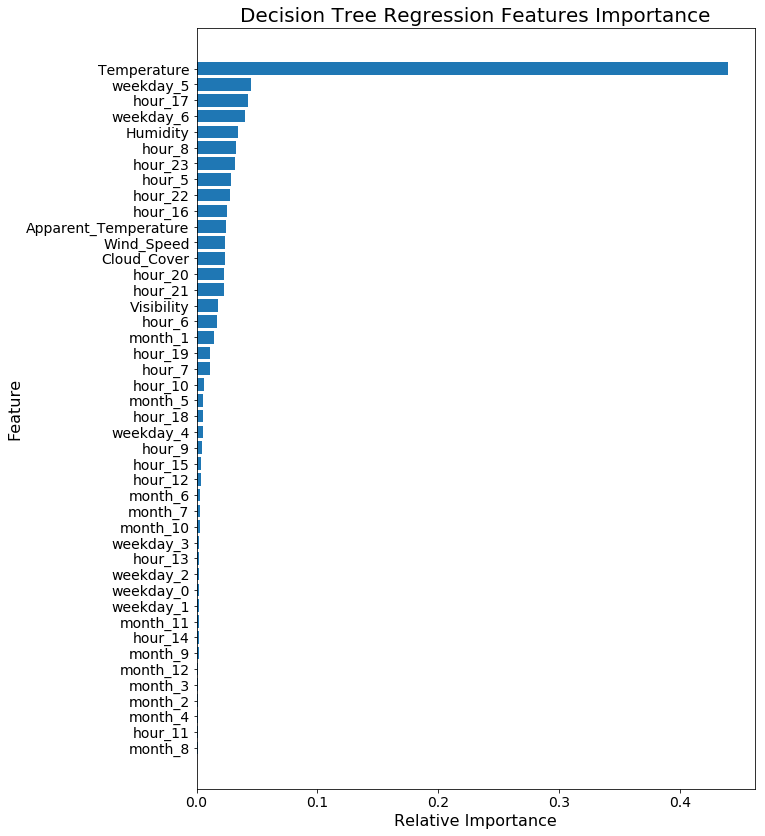

In [61]:
plot_feature_importances(dtr, 'Decision Tree Regression')

In [62]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 0.965
Testing Set Score: 0.793


,Random Forest Regression
R Squared,0.890547
RMSE,291.954553


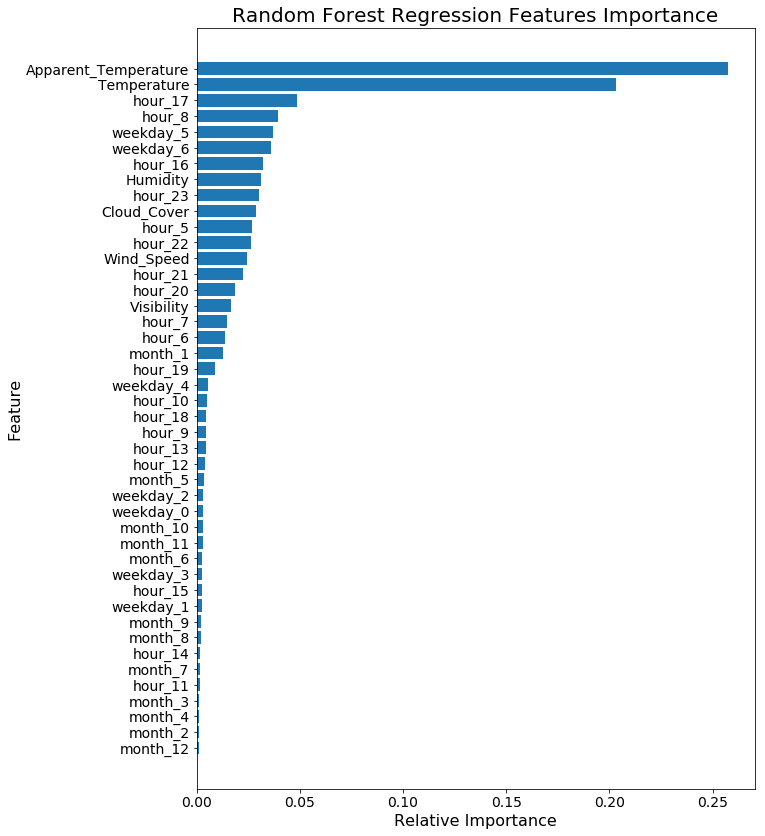

In [63]:
plot_feature_importances(rfr, 'Random Forest Regression')

#### Extra Trees Regression

In [64]:
# Extra Trees Regressor
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.827


,Extra Trees Regression
R Squared,0.909531
RMSE,243.740303


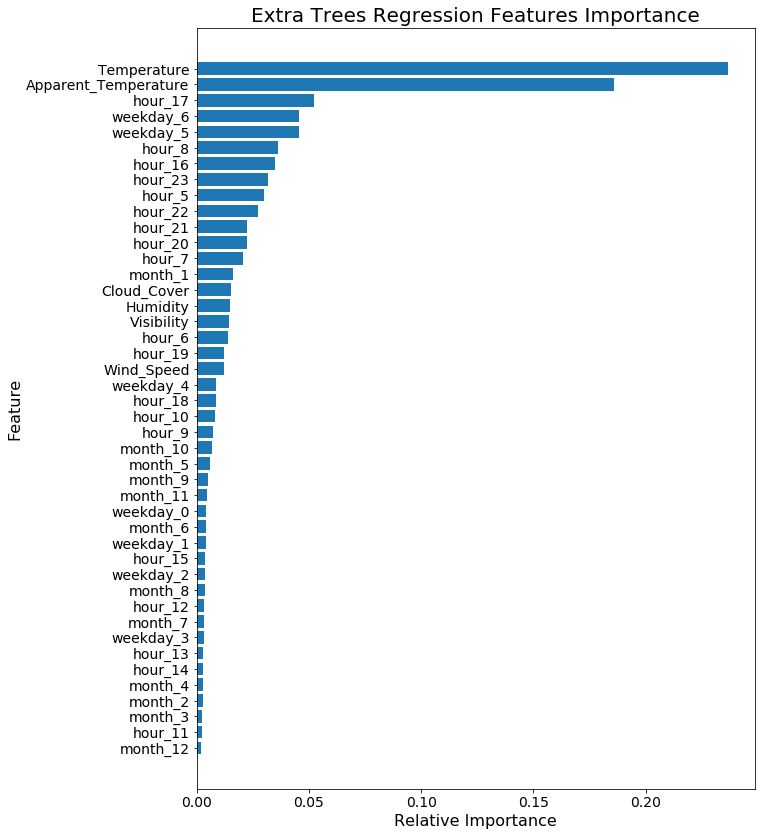

In [65]:
plot_feature_importances(etr, 'Extra Trees Regression')

#### Nearest Neighbors Regression

In [66]:
# Nearest Neighbors Regressor
knr = KNeighborsRegressor(n_neighbors=10)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 0.575
Testing Set Score: 0.453


,Nearest Neighbors Regression
R Squared,0.672958
RMSE,771.947906


## Regression Summary - Categorical Feature Set

In [67]:
# Regression Summary
print("Regression Summary - Categorical Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics,
                                dtr_metrics, rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary - Categorical Feature Set


,Linear Regression,Lasso Regression,Ridge Regression,Bayesion Ridge Regression,Decision Tree Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression
R Squared,0.809501,0.809247,0.809247,0.809243,0.797272,0.890547,0.909531,0.672958
RMSE,486.352625,486.932107,486.932107,486.941279,514.075159,291.954553,243.740303,771.947906


## 3. Modeling - Selected Features

In [68]:
data = dML.copy(deep=True)

In [69]:
data.rename(columns = {'cloudCover': 'Cloud_Cover', 'temperature': 'Temperature', 'apparentTemperature' : 'Apparent_Temperature',
                     'windSpeed' : 'Wind_Speed', 'humidity' : 'Humidity', 'visibility' : 'Visibility'}, inplace = True)

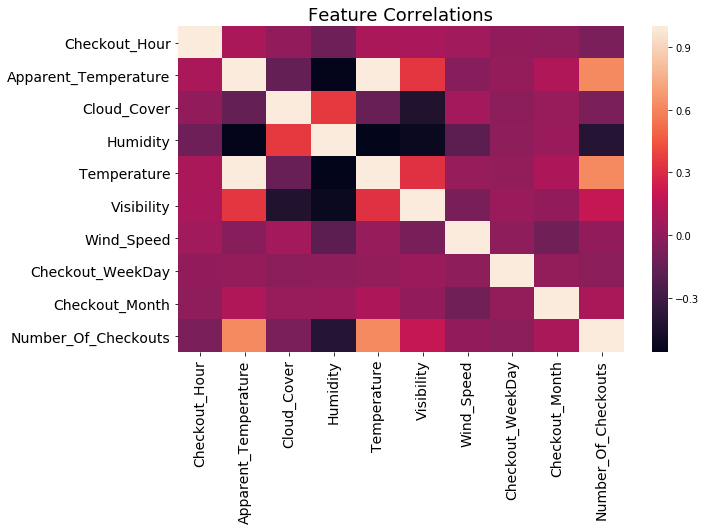

In [70]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility',
            'Number_Of_Checkouts']
plt.figure(figsize=(10,6))
ax = sns.heatmap(data.corr())
plt.title("Feature Correlations", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [71]:
data = data[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]

In [72]:
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
            'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data['Number_Of_Checkouts']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [73]:
array = data.values
X = array[:,0:9]
X[0]

array([ 1.  ,  6.  ,  7.  , 38.74, 33.54,  0.17,  7.14,  0.44, 10.  ])

In [74]:
y = array[:,9]
y[0]

2.0

In [75]:
features = ["Checkout_Month", "Checkout_WeekDay", 'Checkout_Hour', 'Temperature', 
            'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
X = data[features]
y = data["Number_Of_Checkouts"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [76]:
def plot_feature_importances(model, plot_title):
    n_features = X.shape[1]
    plt.figure(figsize=(10,6))
    feature_importance = model.feature_importances_
    features_list = features
    feature_importance, features_list = zip(*sorted(zip(feature_importance, features_list)))
    plt.barh(range(len(features_list)), feature_importance, align='center')
    plt.xticks(fontsize=14)
    plt.yticks(np.arange(len(features_list)), features_list, fontsize=14)
    plt.xlabel('Relative Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title(plot_title + ' Features Importance', fontsize=20)
    plt.show()

### Linear Regression

In [77]:
# Linear Regression
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_predict = lr.predict(X_test)
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print("\nTraining Set Score: {:.3f}".format(lr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lr.score(X_test, y_test)))
lr_metrics = get_regression_metrics('Linear Regression', y_test, y_predict)
lr_metrics

lr.coef_: [  0.40295221  -0.33293635  -0.97766745   1.34835128  -0.0744434
   8.09627771  -0.41860303 -23.66404265  -1.7090385 ]
lr.intercept_: 19.858924715957635

Training Set Score: 0.431
Testing Set Score: 0.394


,Linear Regression
R Squared,0.627964
RMSE,844.014548


### Lasso Regression

In [78]:
# Lasso Regression
lso = linear_model.Lasso(alpha=0.1)
lso.fit(X_train, y_train)
y_predict = lso.predict(X_test)
print("Training Set Score: {:.3f}".format(lso.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(lso.score(X_test, y_test)))
lso_metrics = get_regression_metrics('Lasso Regression', y_test, y_predict)
lso_metrics

Training Set Score: 0.430
Testing Set Score: 0.393


,Lasso Regression
R Squared,0.627204
RMSE,845.345175


### Ridge Regression

In [79]:
# Ridge Regression
rge = linear_model.Lasso(alpha=0.1)
rge.fit(X_train, y_train)
y_predict = rge.predict(X_test)
print("Training Set Score: {:.3f}".format(rge.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rge.score(X_test, y_test)))
rge_metrics = get_regression_metrics('Ridge Regression', y_test, y_predict)
rge_metrics

Training Set Score: 0.430
Testing Set Score: 0.393


,Ridge Regression
R Squared,0.627204
RMSE,845.345175


### Bayesian Ridge Regression

In [80]:
# Bayesian Ridge Regression
brr = linear_model.BayesianRidge()
brr.fit(X_train, y_train)
y_predict = brr.predict(X_test)
print("Training Set Score: {:.3f}".format(brr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(brr.score(X_test, y_test)))
brr_metrics = get_regression_metrics('Bayesion Ridge Regression', y_test, y_predict)
brr_metrics

Training Set Score: 0.431
Testing Set Score: 0.394


,Bayesion Ridge Regression
R Squared,0.627795
RMSE,844.311537


### Decision Tree Regression

In [81]:
# Decision Tree Regression
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, y_train)
y_predict = dtr.predict(X_test)
print("Training Set Score: {:.3f}".format(dtr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(dtr.score(X_test, y_test)))
dtr_metrics = get_regression_metrics('Decision Tree Regression', y_test, y_predict)
dtr_metrics

Training Set Score: 1.000
Testing Set Score: 0.703


,Decision Tree Regression
R Squared,0.838367
RMSE,414.078216


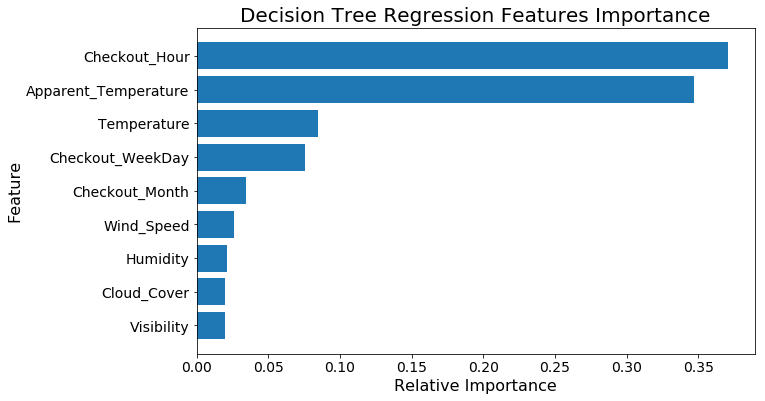

In [82]:
plot_feature_importances(dtr, 'Decision Tree Regression')


### Random Forest Regression

In [83]:
# Random Forest Regression
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)
y_predict = rfr.predict(X_test)
print("Training Set Score: {:.3f}".format(rfr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(rfr.score(X_test, y_test)))
rfr_metrics = get_regression_metrics('Random Forest Regression', y_test, y_predict)
rfr_metrics

Training Set Score: 0.970
Testing Set Score: 0.827


,Random Forest Regression
R Squared,0.909444
RMSE,240.959898


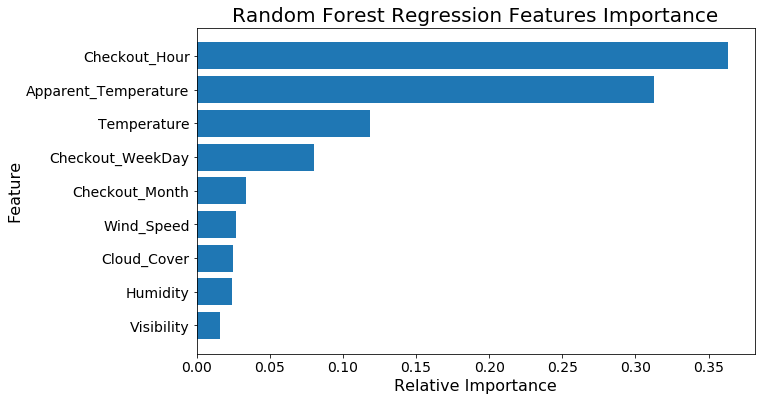

In [84]:
plot_feature_importances(rfr, 'Random Forest Regression')

### Extra Trees Regression

In [85]:
# Extra Trees Regression
etr = ExtraTreesRegressor(random_state=0)
etr.fit(X_train, y_train)
y_predict = etr.predict(X_test)
print("Training Set Score: {:.3f}".format(etr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(etr.score(X_test, y_test)))
etr_metrics = get_regression_metrics('Extra Trees Regression', y_test, y_predict)
etr_metrics

Training Set Score: 1.000
Testing Set Score: 0.827


,Extra Trees Regression
R Squared,0.909507
RMSE,240.800164


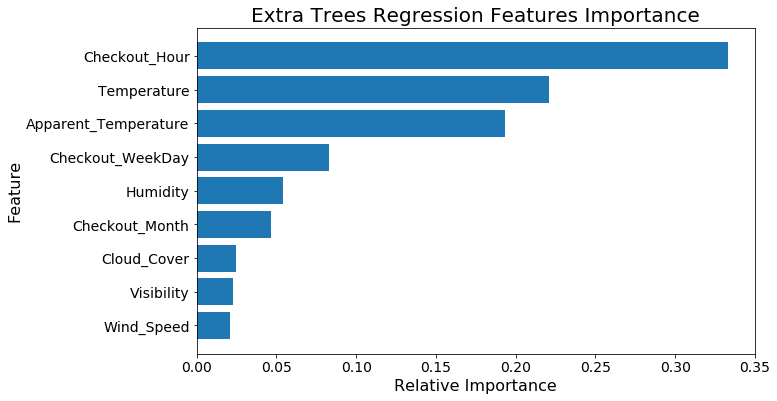

In [86]:
plot_feature_importances(etr, 'Extra Trees Regression')

### Nearest Neighbors Regression

In [87]:
# Nearest Neighbors Regression
knr = KNeighborsRegressor(n_neighbors=2)
knr.fit(X_train, y_train)
y_predict = knr.predict(X_test)
print("Training Set Score: {:.3f}".format(knr.score(X_train, y_train)))
print("Testing Set Score: {:.3f}".format(knr.score(X_test, y_test)))
knr_metrics = get_regression_metrics('Nearest Neighbors Regression', y_test, y_predict)
knr_metrics

Training Set Score: 0.888
Testing Set Score: 0.610


,Nearest Neighbors Regression
R Squared,0.780789
RMSE,543.995888


## Regression Summary with Numerical Feature Set

In [88]:
# Regression Summary
print("Regression Summary With Numericical Feature Set")
regression_metrics = pd.concat([lr_metrics, lso_metrics, rge_metrics, brr_metrics, dtr_metrics,
                                rfr_metrics, etr_metrics, knr_metrics] , axis=1)
regression_metrics.sort_index()

Regression Summary With Numericical Feature Set


,Linear Regression,Lasso Regression,Ridge Regression,Bayesion Ridge Regression,Decision Tree Regression,Random Forest Regression,Extra Trees Regression,Nearest Neighbors Regression
R Squared,0.627964,0.627204,0.627204,0.627795,0.838367,0.909444,0.909507,0.780789
RMSE,844.014548,845.345175,845.345175,844.311537,414.078216,240.959898,240.800164,543.995888


## Test Random Forest Regressor on Unseen Samples

In [89]:
dUT = dUT[['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour', 'Temperature', 'Apparent_Temperature',
             'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility', 'Number_Of_Checkouts']]
features = ['Checkout_Month', 'Checkout_WeekDay', 'Checkout_Hour',  
                 'Temperature', 'Apparent_Temperature', 'Cloud_Cover', 'Wind_Speed', 'Humidity', 'Visibility']
pred_X = dUT[features]
act_y = dUT['Number_Of_Checkouts']
pred_array = dUT.values
pred_X_array = pred_array[:,0:9]
act_y_array = pred_array[:,9]
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X, y)
pred = rfr.predict(pred_X_array)
print('pred =', pred)
print('act = ', act_y_array)

pred = [ 21.8  10.3  48.5   1.9  29.5 117.2  79.6   8.7 118.8 126.5]
act =  [ 21.   7.  44.   2.  25. 100.  83.  11. 129. 126.]


## 4. Summary

With reduced features, the Random Forest model attains the highest accuracy with the lowest RMSE. The linear models have almost four times higher RMSE values as compared to the Random Forest model. This suggests that the prediction can be improved even with reduced features.